We need to :

1. generate data
2. define priors in lim space
3. do inference in limited space
4. in inference expand space for update
5. shrink back for global update 
6. repeat till convergence

Stuff thats different :

Dirichlet(a_11 , ... , a_1n )= Dirichlet (a_12, ... ,a_1N) i.e. the diagonal entry of the transition matrix is set to 0 


In [1]:
from test_hsmmbatchcd import *

for i in range(1):
    test_hsmmbatchcd()

/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


NameError: name 'hmm' is not defined

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
from pybasicbayes.distributions import Gaussian
from sklearn.cluster import KMeans

In [6]:
centers = np.array([np.array([0,0]),np.array([4,4]),np.array([0,6]),np.array([8,6])])


K = 4           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 1.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0 ,0.3,0.6,0.1],
    [0.2, 0 ,0.7,0.1],
    [0.7,0.2, 0 ,0.1],
    [0.7,0.2,0.1, 0 ]
    ])

N = 2000
lambda_js = np.arange(1,K+1)*2 + 2


from generate_data import *
emit = make_emissions(centers , kappa_0, nu_0)

seq_hsmm, ind = generate_states_pois(T,lambda_js,N)



obs_hsmm = generate_data(emit,ind)

NameError: name 'generate_states_pois' is not defined

In [211]:
lambda_js

array([ 4,  6,  8, 10])

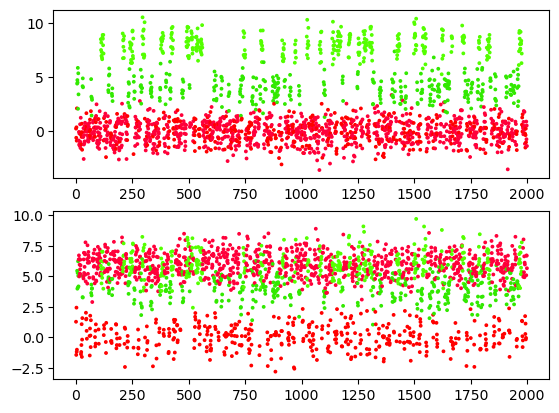

In [212]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm ,cmap = 'prism')
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm ,cmap = 'prism')

In [213]:
# hmmbase.py
import abc
import types

import numpy as np
import numpy.linalg as npl

# This is just for debugging
try:
    import matplotlib.pyplot as plt
except ImportError:
    pass

import pickle as pkl
import itertools

from matrix_expansion import *
from copy import deepcopy

from numpy import newaxis as npa
from scipy.special import digamma, gammaln

import scipy.spatial.distance as dist

import util

# This is for taking logs of things so we don't get -inf
eps = 1e-9


class VariationalHSMMBase(object, metaclass=abc.ABCMeta):
    """ Abstract base class for finite variational HMMs.  Provides the
        interface, basic structure and functions that all implementations will
        need.
    """

    # Interface

    @abc.abstractmethod
    def global_update():
        pass

    @abc.abstractmethod
    def infer():
        """ Perform inference. """
        pass

    @staticmethod
    def make_param_dict(prior_pi0, prior_A, prior_emit, mask=None):
        """ Given parameters make a dict that can be used to initialize an
            object.
        """
        return {'prior_pi0': prior_pi0, 'prior_A': prior_A,
                'prior_emit': prior_emit, 'mask': mask}

    def set_mask(self, mask):
        if mask is None:
            # All observations observed
            self.mask = np.zeros(self.obs.shape[0], dtype='bool')
        else:
            self.mask = mask.astype('bool')

    def __init__(self, obs, prior_pi0, prior_A, prior_emit, m_js,lambda_js, mask=None,
                 init_init=None, init_tran=None, verbose=False, sts=None):
        """
            obs : T x D np array of the observations in D dimensions (Can
                  be a vector if D = 1).

                         hyperparameters.

            prior_A : K x K np array containing the prior parameters
                          for the transition distributions. Use K dirichlet
                          hyperparameters (1 for each row).

            prior_emit : K x 1 np array containing the emission
                          distributions, these should be distributions from
                          pybasicbayes/distributions.py
                          
            m_js,lambda_js : K x 2 np.array governing the matrix expansion 

            mask : 1-d bool array of length T indicating which observations are
                   missing.  1 means missing.

            init_init : 1-d array of size K. Initial initial distribution.  If
                        None, then use the mean of prior_pi0.

            init_tran : 2-d array of size K x K.  Initial transition matrix.
                        If None, then use the row-means of prior_A.

            verbose : Default False.  Print out info while running.

            sts : 2d ndarray of length N.  True state sequence.
        """

        self.verbose = verbose

        self.sts = sts

        # Save the hyperparameters
        self.prior_pi0 = deepcopy(prior_pi0).astype('float64')

        self.prior_A = deepcopy(prior_A).astype('float64')
        self.prior_emit = deepcopy(prior_emit)
###
        # initialize sequences used for langrock and zuccini expansion
        self.m_js = deepcopy(m_js).astype('int')
        self.lambda_js = deepcopy(lambda_js).astype('int')
###

        # Initialize global variational distributions.
        self.var_pi0 = prior_pi0 / np.sum(prior_pi0)
        self.var_A = prior_A / np.sum(prior_A, axis=1)[:,np.newaxis]
        
        # We copy the prior objects becase the mean and covariance are the
        # initial values which can be set randomly when the object is created.
        self.var_emit = deepcopy(prior_emit)

        # Save the observations
        self.obs = obs
        self.set_mask(mask)

        # Number of states
        self.K = prior_A.shape[0]
        self.M = np.sum(self.m_js)

        # Initialize global variational distributions over the extended state space 

        intermediate_mat = prior_A 
        np.fill_diagonal(intermediate_mat, 0)
        intermediate_mat = intermediate_mat / np.sum(intermediate_mat, axis=1)[:,np.newaxis]
        self.var_B =  expand_matrix(intermediate_mat,self.lambda_js,self.m_js)

        self.var_pi0_ext = np.ones(self.M)/self.M
        self.prior_pi0_ext = np.ones(self.M)



        if obs.ndim == 1:
            self.T = obs.shape[0]
            self.D = 1
        elif obs.ndim == 2:
            self.T, self.D = obs.shape
        else:
            raise RuntimeError("obs must have 1 or 2 dimensions")

        self.elbo = -np.inf

    def lower_bound(self):
        """ Compute variational lower-bound.  This is approximate when
            stochastic optimization is used.
        """

        elbo = 0.

        # Initial distribution (only if more than one series, so ignore for now)
        p_pi = self.prior_pi0
        p_pisum = np.sum(p_pi)
        q_pi = self.var_pi0
        q_pidg = digamma(q_pi + eps)
        q_pisum = np.sum(q_pi)
        dg_q_pisum = digamma(q_pisum + eps)

        # Energy
        pi_energy = (gammaln(p_pisum + eps) - np.sum(gammaln(p_pi + eps))
                     + np.sum((p_pi-1.)*(q_pidg - dg_q_pisum)))
        # Entropy
        pi_entropy = -(gammaln(q_pisum + eps) - np.sum(gammaln(q_pi + eps))
                       + np.sum((q_pi-1.)*(q_pidg - dg_q_pisum)))

        # Transition matrix (each row is Dirichlet so can do like above)
        p_A = self.prior_A
        p_Asum = np.sum(p_A, axis=1)
        q_A = self.var_A
        q_Adg = digamma(q_A + eps)
        q_Asum = np.sum(q_A, axis=1)
        dg_q_Asum = digamma(q_Asum + eps)

        A_energy = (gammaln(p_Asum + eps) - np.sum(gammaln(p_A + eps), axis=1)
                    + np.sum((p_A-1)*(q_Adg - dg_q_Asum[:,npa]), axis=1))
        A_entropy = -(gammaln(q_Asum + eps) - np.sum(gammaln(q_A + eps), axis=1)
                     + np.sum((q_A-1)*(q_Adg - dg_q_Asum[:,npa]), axis=1))
        A_energy = np.sum(A_energy)
        A_entropy = np.sum(A_entropy)

        # Emission distributions -- does both energy and entropy
        emit_vlb = 0.
        for k in range(self.K):
            emit_vlb += self.var_emit[k].get_vlb()

        # Data term and entropy of states
        # This amounts to the sum of the logs of the normalization terms from
        # the forwards pass (see Beal's thesis).
        # Note: We use minus here b/c c_table is the inverse of \zeta_t in Beal.
        #lZ = -np.sum(np.log(self.c_table + eps))

        # We don't need the minus anymore b/c this is 1/ctable
        lZ = np.sum(np.logaddexp.reduce(self.lalpha, axis=1))

        elbo = (pi_energy + pi_entropy + A_energy + A_entropy
                + emit_vlb + lZ)

        return elbo

    def local_update(self, obs=None, mask=None):
        """ This is the local update for the batch version. Here we're creating
            modified parameters to run the forward-backward algorithm on to
            update the variational q distribution over the hidden states.

            These are always the same, and if we really need to change them
            we'll override the function.
        """
        if obs is None:
            obs = self.obs
        if mask is None:
            mask = self.mask


# this is a sequence of a,b a,b equations pairs going from hmm to extended hsmm formulation       # 
###
        self.pi_tilde = digamma(self.var_pi0 + eps) - digamma(np.sum(self.var_pi0) + eps) # ??
        tran_sum = np.sum(self.var_A, axis=1)

        self.pi_tilde_ext = digamma(self.var_pi0_ext + eps) - digamma(np.sum(self.var_pi0_ext) + eps) # ??
        tran_sum_ext = np.sum(self.var_B, axis=1)
###
###
        self.A_tilde = digamma(self.var_A + eps) - digamma(tran_sum[:,npa] + eps) #11?
        inter_matrix = self.A_tilde
        np.fill_diagonal(inter_matrix,0)
        self.B_tilde = expand_matrix(inter_matrix,self.lambda_js,self.m_js)
        np.fill_diagonal(self.B_tilde,np.diagonal(self.var_B))
###
        # Compute log-likelihoods (only in hsmm space)
        for k, odist in enumerate(self.var_emit):
            self.lliks[:,k] = np.nan_to_num(odist.expected_log_likelihood(obs))

        # update forward, backward and scale coefficient tables
        self.forward_msgs() #12 done in log 
        self.backward_msgs() #13 done in log

###
        self.var_x = self.lalpha + self.lbeta #14 in log self.var_x = q*(x_t=k)
        self.var_x_ext = self.lalpha_tilde + self.lbeta_tilde
###
###
        self.var_x -= np.max(self.var_x, axis=1)[:,npa] 
        self.var_x_ext -= np.max(self.var_x_ext, axis=1)[:,npa] 
###
        #why do we substract the max value? is this step 15??
###
        self.var_x = np.exp(self.var_x)
        self.var_x_ext = np.exp(self.var_x_ext)
###
        # exit log and convert to normal exponential value for normalization in line down
        # we will take the outer product to compute the probabilities kj in the global update 
        # that will update the transitions parameters 
###
        self.var_x /= np.sum(self.var_x, axis=1)[:,npa]
        self.var_x_ext /= np.sum(self.var_x_ext, axis=1)[:,npa]
###     
        print('var_x',self.var_x[1])
        print('var_x_ext',self.var_x_ext[1])
##########################
        for i in range(len(self.m_js)):
            for k in range(self.K):
                if k == 0:
                    self.var_x[:,k] = np.sum(self.var_x_ext[:,0:self.m_js[k]],axis=1)
                else:
                    ind_u = np.sum(self.m_js[:k+1])
                    ind_l = ind_u - self.m_js[k]
                    print('upper:',ind_u)
                    print('lowe',ind_l)
                    self.var_x[:,k] = np.sum(self.var_x_ext[:,ind_l:ind_u],axis=1)


############################

        self.var_x /= np.sum(self.var_x, axis=1)[:,npa]
        print('var_x after transform',self.var_x[1])

        # normalizing step


    def forward_msgs(self, obs=None, mask=None):
        """ Creates an alpha table (matrix) where
            alpha_table[i,j] = alpha_{i}(z_{i} = j) = P(z_{i} = j | x_{1:i}).
            This also creates the scales stored in c_table. Here we're looking
            at the probability of being in state j and time i, and having
            observed the partial observation sequence form time 1 to i.

            obs : iterable of observation indices.  If None defaults to
                    all timestamps.

            See: http://courses.media.mit.edu/2010fall/mas622j/ProblemSets/ps4/tutorial.pdf
                 for an explanation of forward-backward with scaling.

            Override this for specialized behavior.
        """

        if obs is None:
            obs = self.obs
        if mask is None:
            mask = self.mask
###            
        ltran = self.A_tilde
        ltran_ext = self.B_tilde
###
###
        ll = self.lliks
        ll_ext =  np.zeros((self.T,self.M))
        for i in range(self.T):
            row_i = []
            for j in range(self.K):
                row_i = row_i + self.m_js[j]*[ll[i][j]]
            ll_ext[i,:] = np.array(row_i)
###
###
        lalpha = self.lalpha
        lalpha_tilde = self.lalpha_tilde
###
###
        lalpha[0,:] = self.pi_tilde + ll[0,:] #log alpha ll-> pi from tutorial.pdf
        lalpha_tilde[0,:] = self.pi_tilde_ext + ll_ext[0,:] 
###
###
        for t in range(1,self.T):
            lalpha[t] = np.logaddexp.reduce(lalpha[t-1] + ltran.T, axis=1) + ll[t]
            lalpha_tilde[t] = np.logaddexp.reduce(lalpha_tilde[t-1] + ltran_ext.T, axis=1) + ll_ext[t]

    def backward_msgs(self, obs=None, mask=None):
        """ Creates a beta table (matrix) where
            beta_table[i,j] = beta_{i}(z_{i} = j) = P(x_{i+1:T} | z_{t} = j).
            This also scales the probabilies. Here we're looking at the
            probability of observing the partial observation sequence from time
            i+1 to T given that we're in state j at time t.

            Override this for specialized behavior.
        """

        if obs is None:
            obs = self.obs
        if mask is None:
            mask = self.mask

###            
        ltran = self.A_tilde
        ltran_ext = self.B_tilde
###
###
        ll = self.lliks
        ll_ext =  np.zeros((self.T,self.M))
        for i in range(self.T):
            row_i = []
            for j in range(self.K):
                row_i = row_i + self.m_js[j]*[ll[i][j]]
            ll_ext[i,:] = np.array(row_i)
###
###
        lbeta = self.lbeta
        lbeta_tilde = self.lbeta_tilde
###
###
        lbeta[self.T-1,:] = 0. #log of 1 
        lbeta_tilde[self.T-1,:] = 0. #log of 1 
###
###
        for t in range(self.T-2,-1,-1):
            np.logaddexp.reduce(ltran + lbeta[t+1] + ll[t+1], axis=1,
                                out=lbeta[t])
            np.logaddexp.reduce(ltran_ext + lbeta_tilde[t+1] + ll_ext[t+1], axis=1,
                                out=lbeta_tilde[t])
###

    def pred_logprob(self):
        """ Compute vector of predictive log-probabilities of data marked as
            missing in the `mask` member.

            Returns None if no missing data.
        """
        K = self.K
        obs = self.obs
        mask = self.mask
        nmiss = np.sum(mask)
        if nmiss == 0:
            return None

        logprob = np.zeros((nmiss,K))

        for k, odist in enumerate(self.var_emit):
            logprob[:,k] = np.log(self.var_x[mask,k]+eps) + odist.expected_log_likelihood(obs[mask,:])

        return np.mean(np.logaddexp.reduce(logprob, axis=1))



In [214]:
# hmmbatchcd.py


import sys
import time
import numpy as np

# This is just for debuggin
try:
    import matplotlib.pyplot as plt
except ImportError:
    pass

from copy import deepcopy

# from hmmbase import VariationalHMMBase
from pybasicbayes import distributions as dist

# This is for taking logs of things so we don't get -inf
eps = 1e-9


class VBHSMM(VariationalHSMMBase):
    """ Batch coordinate-descent variational inference for hidden Markov
        models.

        obs : observations
        x : hidden states
        init : initial distribution (only useful for multiple series)
        tran : transition matrix
        emit : emission distributions

        The user passes in the hyperparameters for the initial, transition and
        emission distribution. We then store these as hyperparameters, and make
        copies of them to use as the variational parameters, these are the
        parameters we're doing updates on.

        The user should have each unique observation indexed in the emission
        hyperparameters and have those corresponding indexes listed in the
        observations. This way the user wont have to provide a map from the
        indexes to the observations, also it's a lot easier to deal with
        indexes than observations.
    """

    def __init__(self, obs, prior_pi0, prior_A, prior_emit,m_js,lambda_js, mask=None,
                 init_init=None, init_tran=None, epsilon=1e-10, maxit=1000,
                 verbose=False, sts=None):
        """
            obs : T x D np array of the observations in D dimensions (Can
                  be a vector if D = 1).

            prior_pi0 : 1 x K np array containing the prior parameters
                         for the initial distribution.  Use Dirichlet
                         hyperparameters.

            prior_A : K x K np array containing the prior parameters
                          for the transition distributions. Use K dirichlet
                          hyperparameters (1 for each row).

            prior_emit : K x 1 np array containing the emission
                          distributions, these should be distributions from
                          pybasicbayes/distributions.py

            mask : 1-d bool array of length T indicating which observations are
                   missing.  1 means missing.

            init_init : 1-d array of size K. Initial initial distribution.  If
                        None, then use the mean of prior_pi0.

            init_tran : 2-d array of size K x K.  Initial transition matrix.
                        If None, then use the row-means of prior_A.

            epsilon : Threshold to decide algorithm has converged.  Default
                      1e-8.

            maxit : Maximum number of iterations to run optimization.
                    Default is 100.
        """

        super(VBHSMM, self).__init__(obs, prior_pi0, prior_A, prior_emit,
                                     m_js,lambda_js,
                                    mask=mask, init_init=init_init,
                                    init_tran=init_tran, verbose=verbose,
                                    sts=sts)

        self.epsilon = epsilon
        self.maxit = maxit

        # Need to do this in the derived class because the sizes are different
        # depending on if we're batch or stochastic.
        # var_x is a T x K matrix so the k'th column represents the k'th
        # state over all T observations. So q[t,k] would represent the weight
        # for the k'th state at time t.
        self.var_x = np.random.rand(self.T, self.K)
        self.var_x /= np.sum(self.var_x, axis=1)[:,np.newaxis]

        # These are all members so we don't have to reinitialize them every
        # time we call the forward and backward functions
        #self.alpha_table = np.zeros((self.T, self.K))
        #self.beta_table = np.zeros((self.T, self.K))
        #self.c_table = np.zeros(self.T)

        self.lalpha = np.empty((self.T, self.K))
        self.lbeta = np.empty((self.T, self.K))
        self.lliks = np.empty((self.T, self.K))

        self.lalpha_tilde = np.empty((self.T, self.M))
        self.lbeta_tilde = np.empty((self.T, self.M))
        self.lliks_tilde = np.empty((self.T, self.M))

        # The modified parameters used in the local update
        self.pi_tilde = np.zeros(self.K)
        self.A_tilde = np.zeros((self.K, self.K))

        self.pi_tilde_extended = np.zeros(self.M)

        # the variable to save the extended space log q(x)
        self.var_x_ext = np.empty((self.T, self.M))


        # Stuff for viterbi that we don't use.  It could go in hmmbase.py
        #self.a_table = np.zeros((self.T, self.K))
        #self.viterbi_table = np.zeros((self.T, self.K))

    def infer(self):
        """ Run batch variational with coordinate descent on the full data set.

            epsilon : [default 1e-8] when ELBO has converged
            maxit : [default 100] number of iterations to run

        """

        # Put nans in obs and restore afterwards
        self.obs_full = self.obs.copy()
        self.obs[self.mask,:]

        epsilon = self.epsilon
        maxit = self.maxit

        self.elbo_vec = np.inf*np.ones(maxit)
        self.pred_logprob_mean = np.nan*np.ones(maxit)
        self.pred_logprob_std = np.nan*np.ones(maxit)

        self.iter_time = np.nan*np.ones(maxit)
    
        for it in range(maxit):

            start_time = time.time()

            self.local_update()
            print('local done')
            self.global_update()
            print('global done')

            self.iter_time[it] = time.time() - start_time

            lb = self.lower_bound()
            if self.verbose:
                print("iter: %d, ELBO: %.2f" % (it, lb))
                sys.stdout.flush()

# chganged this from the initial formulation which used atol (early termination of algorithm before convergence)
            
            if np.abs(lb - self.elbo) <= epsilon : #np.allclose(lb, self.elbo, rtol=epsilon):
                print(np.abs(lb - self.elbo) <= epsilon)
                print(f'terminated early - convergence, \n elbo : {self.elbo} \n lower bound : {lb}', )
                print(f'allclose  = {np.allclose(lb, self.elbo, rtol=epsilon)}, diff : {self.elbo - lb}')
                break
            else:
                self.elbo = lb
                self.elbo_vec[it] = lb
                tmp = self.pred_logprob()
                if tmp is not None:
                    self.pred_logprob_mean[it] = np.mean(tmp)
                    self.pred_logprob_std[it] = np.std(tmp)

        lbidx = np.where(np.logical_not(np.isinf(self.elbo_vec)))[0]
        self.elbo_vec = self.elbo_vec[lbidx]
        self.pred_logprob_mean = self.pred_logprob_mean[lbidx]
        self.pred_logprob_std = self.pred_logprob_std[lbidx]
        self.iter_time = self.iter_time[lbidx]

        # Save Hamming distance
        if self.sts is not None:
            self.hamming, self.perm = self.hamming_dist(self.var_x, self.sts)

        # Restore original data
        self.obs = self.obs_full

    def global_update(self):
        """ This is the global update for the batch version. Here we're
            updating the hyperparameters of the variational distributions over
            the parameters of the HMM.
        """

        # Initial parameter update
        self.var_pi0 = self.prior_pi0 + self.var_x[0,:]
        self.var_pi0_ext = self.prior_pi0_ext + self.var_x_ext[0,:]


        # Transition parameter updates
        self.var_A = self.prior_A.copy()
        self.var_B = expand_matrix(self.prior_A.copy(),self.lambda_js,self.m_js)

        for t in range(1, self.T):
            self.var_A += np.outer(self.var_x[t-1,:], self.var_x[t,:]) # eq 15 from local 
            # update ( only used when computing the transition probabilities ) supplementary (7) to equation
            # hyperparams dirichle row (alphas) + the quantities expe vale by takignthe first
            # sum in the eqs and they do one by the other one instead of ding the actual joint 

        np.fill_diagonal(self.var_A,0)   

        # Emission parameter updates
        inds = np.logical_not(self.mask)
        for k in range(self.K):
            self.var_emit[k].meanfieldupdate(self.obs[inds,:], self.var_x[inds,k])


In [215]:
kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs_hsmm.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emissions for each super state
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_A = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
np.fill_diagonal(prior_A, 0)

prior_pi0 = np.ones(K)                     # ?
# -----------------------------------------------------------------
# page break
m_js,lambda_js = np.ones(K)*10, np.array(lambda_js)



var_x [1.51935637e-059 1.00000000e+000 1.40241731e-157 3.34729390e-019]
var_x_ext [1.13722037e-058 1.95555970e-058 1.92499040e-058 1.90252068e-058
 1.88683066e-058 1.87585174e-058 1.86799508e-058 1.86221276e-058
 1.85783736e-058 1.85444154e-058 9.47301792e-002 1.09629836e-001
 1.07447643e-001 1.04689664e-001 1.01806480e-001 9.91324688e-002
 9.68139655e-002 9.48686961e-002 9.32582912e-002 9.76227763e-002
 1.06850508e-156 1.86638356e-156 1.85762778e-156 1.84376934e-156
 1.82654071e-156 1.80852737e-156 1.79174195e-156 1.77716045e-156
 1.76497153e-156 1.75496275e-156 2.55175829e-018 4.46460997e-018
 4.45828809e-018 4.44487331e-018 4.42266764e-018 4.39258778e-018
 4.35777130e-018 4.32192596e-018 4.28792723e-018 4.25736981e-018]
upper: 20
lowe 10
upper: 30
lowe 20
upper: 40
lowe 30
upper: 20
lowe 10
upper: 30
lowe 20
upper: 40
lowe 30
upper: 20
lowe 10
upper: 30
lowe 20
upper: 40
lowe 30
upper: 20
lowe 10
upper: 30
lowe 20
upper: 40
lowe 30
var_x after transform [1.81254603e-057 1.00000000e+

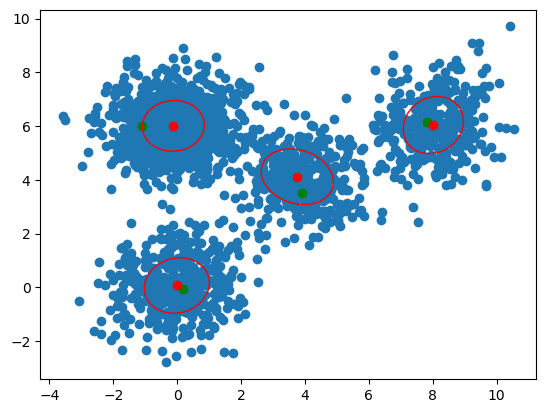

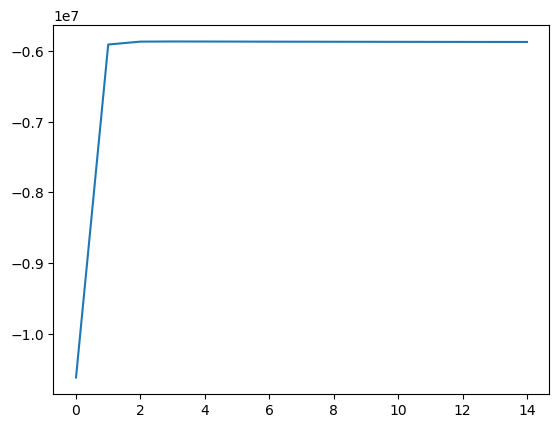

In [216]:
import hmmbatchcd as HSMM
import util

# define object for inferrence from hmmbatchcd.py
# # pass priors on init transitions and emissions for each state
hmm = VBHSMM(obs_hsmm, prior_pi0, prior_A, prior_emit,m_js,lambda_js,maxit=15, epsilon=10**(-10))  
hmm.infer() # do inference 
sts_true = seq_hsmm # true states 
# hamming distance
##print(prior_emit[0].mu_mf)
##print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs_hsmm, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

In [217]:
VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]

for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_A[i][j]

In [218]:
VI_alphas

{'3': {'3': 0.0,
  '1': 75.82077462236437,
  '4': 9.740454162722104,
  '2': 49.21184483950413},
 '1': {'3': 63.80529117946191,
  '1': 0.0,
  '4': 13.683749925568039,
  '2': 39.44315554659655},
 '4': {'3': 4.168982123282153,
  '1': 22.24325519893749,
  '4': 0.0,
  '2': 12.887569595190758},
 '2': {'3': 67.79875395502403,
  '1': 17.868205397044232,
  '4': 15.875602829120194,
  '2': 0.0}}

In [219]:
from scipy.stats import invwishart,t,beta


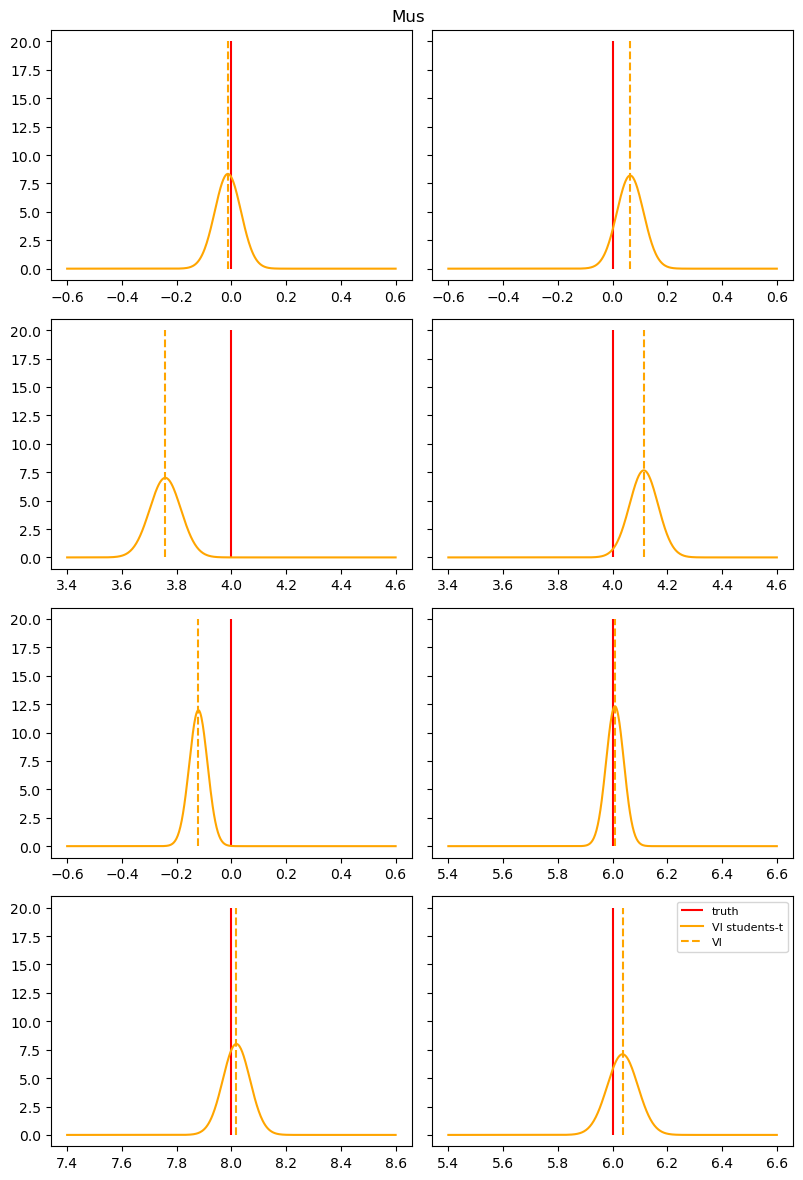

In [223]:
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'red',label='truth')
        x = np.linspace(centers[k][d]-0.6,centers[k][d]+0.6,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI students-t',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')

        # plt.ylim((0,20))
plt.suptitle('Mus')
plt.legend(fontsize = 8)
plt.tight_layout()


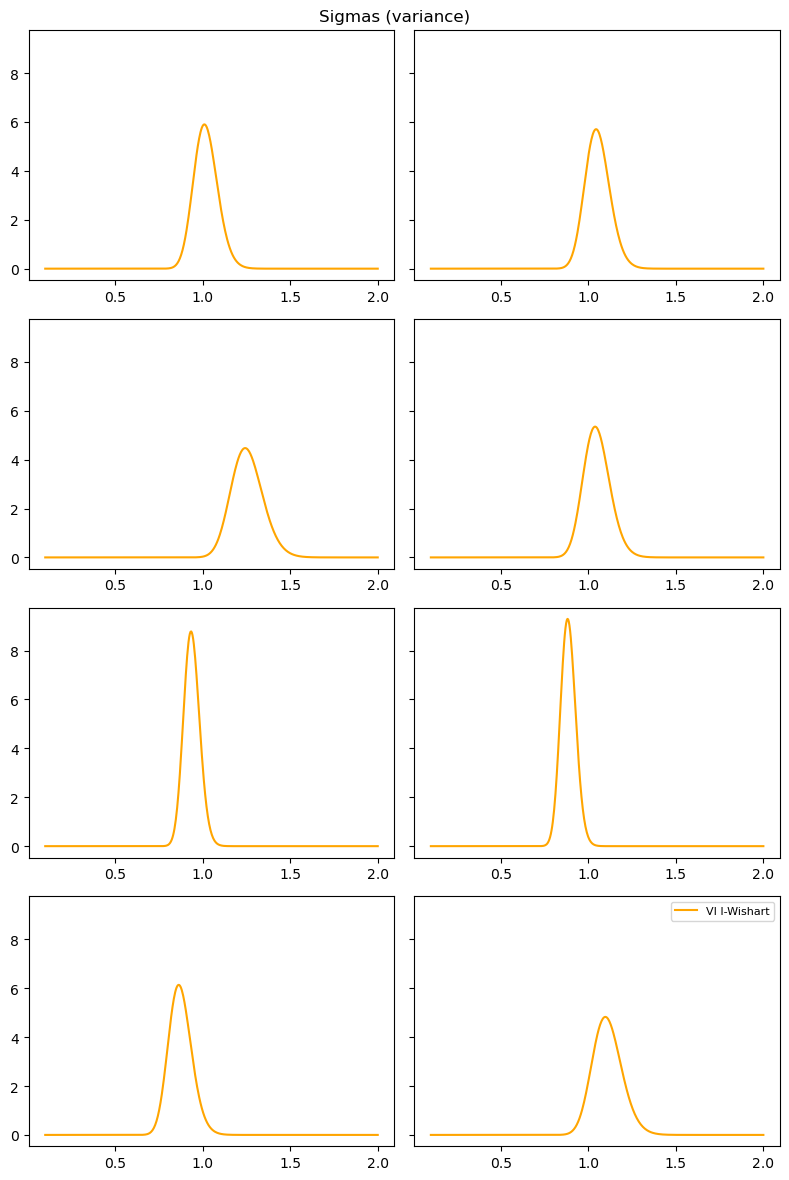

In [221]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        # ax.vlines(1,0,10,color = 'red',label='truth')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigmas (variance)')
plt.legend(fontsize = 8)
plt.tight_layout()

hi


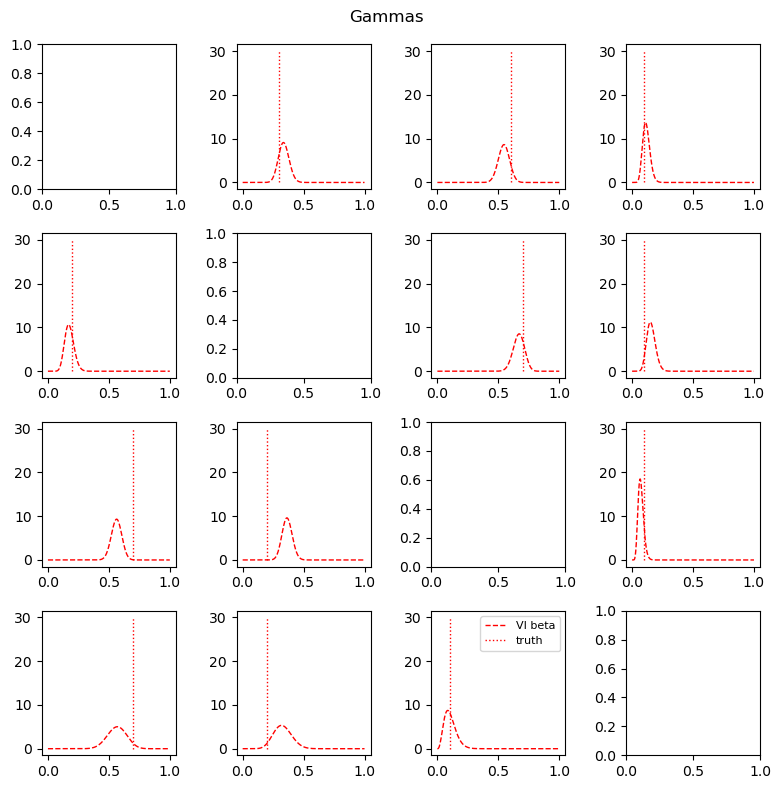

In [228]:
K=4
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        if k==j:
            pass
        else:
            ax = axs[k,j]
            x = np.linspace(0,1,500)
            dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist,label = 'VI beta',color = 'red',linewidth=1.0,linestyle = 'dashed')
            ax.vlines(T[k][j],0,30,color = 'red',label='truth',linewidth=1.0,linestyle = 'dotted')

            # ax.set_xlim(0,1)
            ax.set(ylabel=None)
        if k==(K-1):
            if j==(K-2):
                ax.legend(['VI beta', 'truth'], fontsize=8)



plt.suptitle('Gammas')
plt.tight_layout()
plt.show()

In [105]:
T

array([[0. , 0.3, 0.6, 0.1],
       [0.2, 0. , 0.7, 0.1],
       [0.7, 0.2, 0. , 0.1],
       [0.7, 0.2, 0.1, 0. ]])